# Python Website Reader

Mit diesem Notebook werden die folgenden Websites besucht und die News in Markdown angezeigt und können auch als Markdown-file abgespeichert werden.

Der Pfad und der Filename kann in der aufrufenden Function savefile('D:\\temp', 'srf.md', stream) angepasst werden. Aktuell ist die Function auskommentiert.

<mark>**Bitte zuerst die erste Zelle ausführen, damit die Farben für den Output und der Newsr-Reader geladen sind.**</mark>

In [2]:
# Run this cell to load the colors and the newsreader-function
import requests, html2text
import os, sys, getopt, socket
import locale, re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pymongo, dns

class colors: 
    '''Colors class:reset all colors with colors.reset'''
    reset         = '\033[0m'
    bold          = '\033[01m'
    disable       = '\033[02m'
    underline     = '\033[04m'
    reverse       = '\033[07m'
    strikethrough = '\033[09m'
    invisible     = '\033[08m'

    class fg: 
        ''' Define the foreground-colors, use as colors.fg.colorname
        '''
        black      = '\033[30m'
        red        = '\033[31m'
        green      = '\033[32m'
        orange     = '\033[33m'
        blue       = '\033[34m'
        purple     = '\033[35m'
        cyan       = '\033[36m'
        lightgrey  = '\033[37m'
        darkgrey   = '\033[90m'
        lightred   = '\033[91m'
        lightgreen = '\033[92m'
        yellow     = '\033[93m'
        lightblue  = '\033[94m'
        pink       = '\033[95m'
        lightcyan  = '\033[96m'

    class bg: 
        ''' Define the background-colors, use as colors.bg.colorname
        '''
        black     = '\033[40m'
        red       = '\033[41m'
        green     = '\033[42m'
        orange    = '\033[43m'
        blue      = '\033[44m'
        purple    = '\033[45m'
        cyan      = '\033[46m'
        lightgrey = '\033[47m'

def newsreader(url, search_from, search_to, links=True, images=True, emphasis=True):
    '''Reads the given url and return the content a markdown'''
    response = requests.get(url)
    if(response.status_code == 200):
        html_content = response.content.decode('utf-8')
        # Format to markdown
        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        md_data            = md.handle(html_content)
        #read from start-pattern to end-pattern
        start  = md_data.find(search_from)
        end    = md_data.find(search_to)
        stream = [(md_data[start:end])]

    return stream

# Covid19-CH API
def get_data_version(url):
    '''return JSON-file'''
    from bson.json_util import loads
    response = requests.get(url +"/context")
    if(response.status_code == 200):
        html_content = response.content.decode("utf-8")
        json_data = loads(html_content)
        if "dataVersion" in json_data:
            data = json_data["dataVersion"]
            return data
        else:
            print("dataVersion not found")
    else:
        print(response.status_code)

def get_source_date(url):
    '''return JSON-file'''
    from bson.json_util import loads
    response = requests.get(url +"/context")
    if(response.status_code == 200):
        html_content = response.content.decode('utf-8')
        json_data = loads(html_content)
        if "sourceDate" in json_data:
            data = json_data["sourceDate"]
            return data
        else:
            print("sourceDate not found")
    else:
        print(response.status_code)

def get_apidata(url, type, last_update):
    '''return JSON'''
    from bson.json_util import loads
    data_json_url = f"{url}/sources/COVID19{type}_geoRegion.json"
    #print(data_json_url)
    response = requests.get(data_json_url)
    if(response.status_code == 200):
        html_content = response.content.decode("utf-8")
        json_data = loads(html_content)
        for row in json_data:
            if row["geoRegion"] == "CH":
                if row["datum"] == last_update:
                    return str(row["sumTotal"]) + "\n" + str(row["entries_diff_last"])


def add_document(connectionstring, mongodatabase, collection, document):
    '''Connect to MongoDB and add a document'''
    import pymongo
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[mongodatabase]
    mongo_col    = mongo_db[collection]
    mongo_col.insert_one(document)
    for doc in mongo_col.find():
        print(doc)

    mongo_client.close()


## SRF News
Code mit <mark> Run Cell </mark> ausführen um die SRF News anzuzeigen.

In [ ]:
# Run this cell to get the news from www.srf.ch
url = 'https://www.srf.ch/news/neuste-beitraege'
now = datetime.now()
print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {url}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)

stream = newsreader(url, '###  Neueste Beiträge', '## Footer', False, False)
for i in stream:
    if(i is not None):
        line = i
        line = line.replace('Mit Video\n\n','')
        line = line.replace('Mit Audio\n\n','')
        line = line.replace('###  Neueste Beiträge\n\n','')
        line = line.replace('  * ','### ')
        print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))

## BAG Covid-⁠19 Schweiz
Code mit <mark> Run Cell </mark> ausführen um die aktuellen Covidzahlen vom BAG anzuzeigen.

In [3]:
# Run this cell to get the data from www.covid19.admin and send message to discord.
def send_discord_message(data, date):
    '''Send Discord message'''
    webhook_url         = 'https://discordapp.com/api/webhooks/851028735331008512/JCYUCmlSfAm_Cl0d6mQxyx45RXZae1xR-OU0FIRA8hp1hoMNQzlHx8dHcVSiKeTjB4Fb'
    author_name         = 'Covid19 Hook'
    author_avatar       = 'https://i2.pngguru.com/preview/189/787/605/covid19-coronavirus-corona-violet-pink-purple-cartoon-magenta-smile-png-clipart-thumbnail.jpg'
    section_title       = '[INFO] COVID-19 Statistics for SWITZERLAND'
    section_description = "Information on the current situation, as of " + date

    embeds = {
        "title": section_title, "description": section_description, "color": 32767,
        "fields": [
            {"name" : "Confirmed Cases", "value" : data["Cases"], "inline": "true"},
            {"name" : "Hospitalisations", "value" : data["Hospitalisations"], "inline": "true"},
            {"name" : "Deaths", "value" : data["Deaths"], "inline": "true"},
            {"name" : "Official website", "value" : "[Federal Office of Public Health FOPH | Bundesamt für Gesundheit BAG](https://www.covid19.admin.ch/en/overview?ovTime=total)"}
        ]
    }

    data = {
        "username": author_name, "avatar_url": author_avatar, "embeds": [embeds],
    }

    headers = {
        "Content-Type": "application/json"
    }

    result = requests.post(webhook_url, json=data, headers=headers)
    if 200 <= result.status_code < 300:
        print("[INFO] Webhook sent {0}".format(result.status_code))
    else:
        print("[WARN] Not sent with {0}, response: {1}".format(result.status_code, result.json()))

# Main
api_url      = "https://www.covid19.admin.ch/api/data"
data_version = get_data_version(api_url)
source_date  = get_source_date(api_url)
last_update  = source_date[0:10]

data_version_url = api_url + "/" + data_version
if data_version_url:
    cases = get_apidata(data_version_url, "Cases", last_update)
    hosp  = get_apidata(data_version_url, "Hosp", last_update)
    death = get_apidata(data_version_url, "Death", last_update)
    discord_data = {
        "Cases": cases,
        "Hospitalisations": hosp,
        "Deaths": death,
    }

    dict_data = {
        'Name': ['Neue Fälle', 'Hospitalisationen', 'Todesfälle'],
        'Total': [cases.split('\n')[0], hosp.split('\n')[0], death.split('\n')[0]],
        'Today': [cases.split('\n')[1], hosp.split('\n')[1], death.split('\n')[1]],
    }
    table = pd.DataFrame(data = dict_data)

    print('\n{0}{1}\n{2}{3} NEWS FROM: www.covid19.admin.ch\n{4}{5}\n'.format(colors.bold + colors.fg.blue, '>' * 68, ' ' * 12, last_update, '<' * 68, colors.reset))
    currentdate = datetime.strptime(datetime.strftime((datetime.now()), "%Y-%m-%d"), "%Y-%m-%d")
    daybefore   = datetime.strptime(last_update, "%Y-%m-%d")

    if (daybefore < currentdate):
        print('{0}{1}{2}'.format(colors.fg.yellow, table, colors.reset))
    else:
        print('{0}{1}{2}'.format(colors.fg.green, table, colors.reset))
        #send_discord_message(discord_data, last_update)
        
    print('\n{0}{1}\n{2}ENDE{2}\n{1}{3}'.format(colors.bold + colors.fg.blue, '-' * 68, ' ' * 32, colors.reset))
    


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
            2021-06-18 NEWS FROM: www.covid19.admin.ch
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

                Name   Total Today
0         Neue Fälle  698508   173
1  Hospitalisationen   28857    25
2         Todesfälle   10266     2

--------------------------------------------------------------------
                                ENDE                                
--------------------------------------------------------------------


### Übersicht gesamter Zeitraum

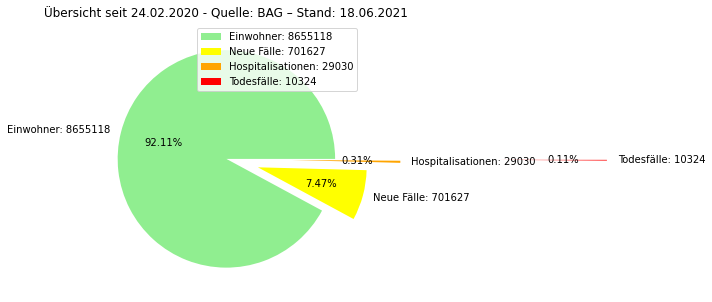

In [4]:
# Create pie chart with data from www.covid19.admin.ch

news = 'https://www.covid19.admin.ch/de/overview?ovTime=total'

# Get data from the website
list_html = newsreader(news, '### Laborbestätigte Fälle', '### Laborbestätigte Hospitalisationen')
for line in list_html:
    if(line is not None):
        Datum = (re.findall('Quelle: BAG – Stand:\s\d{2}\.\d{2}\.\d{4}',line)[0])
        Fälle = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

list_html = newsreader(news, '### Laborbestätigte Hospitalisationen', '### Laborbestätigte Todesfälle')
for line in list_html:
    if(line is not None):
        Hospitalisationen = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

list_html = newsreader(news, '### Laborbestätigte Todesfälle','### Tests und Anteil positive Tests')
for line in list_html:
    if(line is not None):
        Todesfälle = ((re.findall('Total seit 24.02.2020+\|\s\d{1,}\s\d{1,}',line)[0]).split('| ')[1]).replace(' ','')
        break

# Out chart
## Define pie chart
first_value = '24.02.2020'

### Calculate sum of values
sum_of_swiss_people  = 8655118
sum_of_new_cases     = int(Fälle)
sum_of_new_hosp      = int(Hospitalisationen)
sum_of_new_dead      = int(Todesfälle)

### Calculate percent of values
pct_swiss_people     = "{:.2%}".format(1)
pct_new_cases        = "{:.2%}".format(sum_of_new_cases / sum_of_swiss_people)
pct_new_hosp         = "{:.2%}".format(sum_of_new_hosp  / sum_of_swiss_people)
pct_new_dead         = "{:.2%}".format(sum_of_new_dead  / sum_of_swiss_people)

### Create the dictionary
sum_pie_dict = {
    'Summe'  :[sum_of_swiss_people,sum_of_new_cases,sum_of_new_hosp,sum_of_new_dead],
    'Percent':[pct_swiss_people,pct_new_cases,pct_new_hosp,pct_new_dead]
}
#display(sum_pie_df)

### Create the data frame set
sum_pie_df = pd.DataFrame(data=sum_pie_dict)
pie_index  = [
    f'Einwohner: {sum_of_swiss_people}',
    f'Neue Fälle: {sum_of_new_cases}',
    f'Hospitalisationen: {sum_of_new_hosp}',
    f'Todesfälle: {sum_of_new_dead}'
]

### Print out the pie cahrt
sum_plot_colors = ['lightgreen', 'yellow', 'orange', 'red']
sum_pie_explode = (0,0.3,0.6,2.5)
pie = sum_pie_df.plot.pie(
    title   = f"Übersicht seit {first_value} - {Datum}", 
    labels  = pie_index,
    legend  = True,
    ylabel  = "", y = 'Summe',  
    autopct = '%1.2f%%', 
    #table   = True, 
    colors  = sum_plot_colors, 
    explode = sum_pie_explode, 
    figsize = (15,5), 
)

### Save chart as png-file
current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir) 
fig = pie.get_figure()
fig.savefig(f'{parent_dir}/images/covid-overview.png', facecolor='w', bbox_inches='tight')
print()

### MongoDB

Code mit <mark>Run Cell</mark> ausführen um die Daten in die MongoDB abzuspeichern.

In [8]:
# Write data from www.covid19.admin.ch to the MongoDB

news = 'https://www.covid19.admin.ch/de/overview'

def get_htmldata(url, search_from, search_to, links=True, images=True, emphasis=True):
    '''Reads the given url and print a markdown'''
    import requests, html2text, re
    response = requests.get(url)
    if(response.status_code == 200):
        
        html_content = response.content.decode('utf-8')

        # Format to markdown
        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        md_data            = md.handle(html_content)

        #read from start-pattern to end-pattern
        start  = md_data.find(search_from)
        end    = md_data.find(search_to)
        stream = [(md_data[start:end])]

    return stream


def add_document(connectionstring, mongodatabase, collection, document):
    '''Connect to MongoDB and add a document'''
    import pymongo, dns
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[mongodatabase]
    mongo_col    = mongo_db[collection]
    mongo_col.insert_one(document)
    mongo_client.close()


# Process
list_html = get_htmldata(news, '### Laborbestätigte Fälle', '### Laborbestätigte Hospitalisationen')
for line in list_html:
    if(line is not None):

        if re.search('Vortag',line):
            string_to_search = 'Vortag| '
        elif re.search('Mittwoch',line):
            string_to_search = 'Mittwoch| '
        elif re.search('Freitag',line):
            string_to_search = 'Freitag| '

        Datum  = (re.findall('\w+\:\s\d{2}\.\d{2}\.\d{4}',line)[0]).replace('Stand: ','')
        Fälle  = int((re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace(string_to_search,''))
        break

list_html = get_htmldata(news, '### Laborbestätigte Hospitalisationen', '### Laborbestätigte Todesfälle')
for line in list_html:
    if(line is not None):
        Hospitalisationen = int((re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace(string_to_search,''))
        break

list_html = get_htmldata(news, '### Laborbestätigte Todesfälle','### Tests und Anteil positive Tests')
for line in list_html:
    if(line is not None):
        Todesfälle = int((re.findall('[A-Z][a-z]+\|\s\d{1,}',line)[0]).replace(string_to_search,''))
        break

mongodb_doc = {
    'Datum'             : Datum, 
    'Neue Fälle'        : Fälle,
    'Hospitalisationen' : Hospitalisationen,
    'Todesfälle'        : Todesfälle
}

currentdate = datetime.strptime(datetime.strftime((datetime.now()), "%Y-%m-%d"), "%Y-%m-%d")
daybefore   = datetime.strptime(Datum, "%d.%m.%Y")

if (daybefore < currentdate):
    print('{0}{1}{2}'.format(colors.fg.yellow, mongodb_doc, colors.reset))
else:
    credentials = input('user:password')
    connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
    print(mongodb_doc)
    add_document(connectionstring, 'JupyterNB', 'Covid19', mongodb_doc)

{'Datum': '17.06.2021', 'Neue Fälle': 194, 'Hospitalisationen': 78, 'Todesfälle': 7}


Add manual documents

In [ ]:
# Write manual data to the MongoDB
credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
document = {
    "Datum"            : "11.04.2021",
    "Neue Fälle"       : "802",
    "Hospitalisationen": "7",
    "Todesfälle"       : "2"
}
"""
add_document(connectionstring, 'JupyterNB', 'Covid19', document)
"""

### Tagesübersicht mit History

Code mit <mark>Run Cell</mark> ausführen um die MongoDB abzufragen.

In [5]:
# Get history from MongoDB and print it out with pandas
def get_collection(connectionstring, database, collection):
    '''Connect to MongoDB and return data'''
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[database]
    mongo_col    = mongo_db[collection]
    mongo_client.close()
    return mongo_col.find()

## Build history from MongoDB
result_of_history = []
credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
for doc in get_collection(connectionstring, 'JupyterNB', 'Covid19'):
    thisdict = {     
            'UUID'              : doc['_id'],                           
            'Datum'             : datetime.strptime(doc['Datum'], '%d.%m.%Y'),
            'Neue Fälle'        : int(doc['Neue Fälle']),
            'Hospitalisationen' : int(doc['Hospitalisationen']),
            'H/NF'              : "{:.2%}".format(int(doc['Hospitalisationen']) / int(doc['Neue Fälle'])),
            'Todesfälle'        : int(doc['Todesfälle']),
            'T/NF'              : "{:.2%}".format(int(doc['Todesfälle']) / int(doc['Neue Fälle'])),
            'T/H'               : "{:.2%}".format(int(doc['Todesfälle']) / int(doc['Hospitalisationen']))
    }
    result_of_history.append(thisdict)

## Create a data frame set and print out
df = pd.DataFrame(result_of_history)
df.tail(7)

#display(df)

,UUID,Datum,Neue Fälle,Hospitalisationen,H/NF,Todesfälle,T/NF,T/H
82,60c1faef38354fcea06e0220,2021-06-10,358,18,5.03%,6,1.68%,33.33%
83,60c35c92357805ae585aa3e5,2021-06-11,354,24,6.78%,3,0.85%,12.50%
84,60c756bd43bf9019f7d7d4a7,2021-06-14,684,19,2.78%,3,0.44%,15.79%
85,60c8abdb64eb4ebc20ba08ea,2021-06-15,243,14,5.76%,2,0.82%,14.29%
86,60ca11e4bad2d221cd69bc61,2021-06-16,282,19,6.74%,6,2.13%,31.58%
87,60cb5192ad4263b52006532d,2021-06-17,194,78,40.21%,7,3.61%,8.97%
88,60cde600bd0a7625b283cb1d,2021-06-18,173,25,14.45%,2,1.16%,8.00%


,Seit Datum,Avg/Neue Fälle,Avg/Hospitalisationen,Avg/Todesfälle,Sum/Neue Fälle,Sum/Hospitalisationen,Sum/Todesfälle
0,2021-03-23,2113,79,14,188067,7052,1301


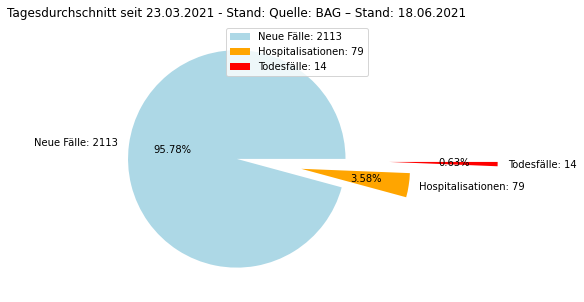

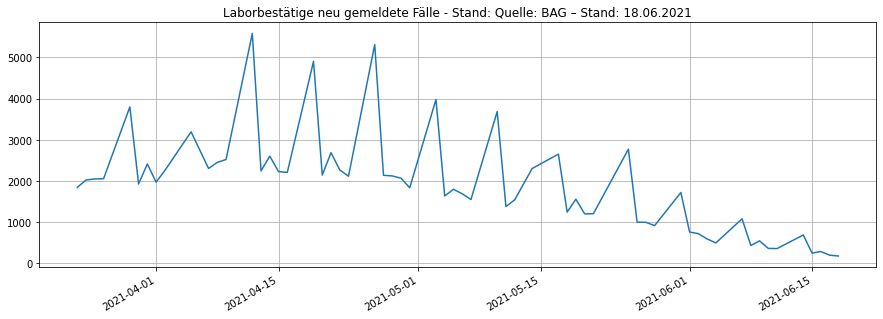

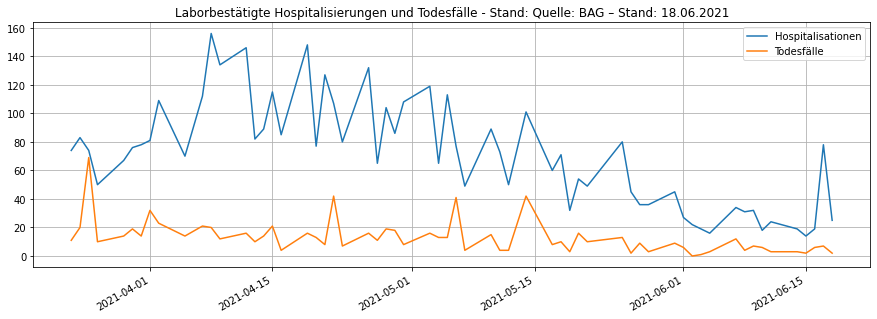

In [7]:
# Create charts with data from MongoDB
current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir) 

count_of_datum = df.Datum.count()
first_value    = str(re.findall('\d{4}\-\d{2}\-\d{2}', str(df.Datum.values[0]))[0])
us_date_fomat  = datetime.strptime(first_value, "%Y-%m-%d")
ch_date_fomat  = datetime.strftime(us_date_fomat, "%d.%m.%Y")
#last_value     = str(re.findall('\d{4}\-\d{2}\-\d{2}', str(df.Datum.values[count_of_datum -1]))[0])
plot_colors    = ['lightblue', 'orange','red']
#pie_index      = ['Neue Fälle','Hospitalisationen','Todesfälle']

## Build sum of data
sum_of_swiss_people = 8655118
sum_of_new_cases    = int(df['Neue Fälle'].sum())
sum_of_new_hosp     = int(df['Hospitalisationen'].sum())
sum_of_new_dead     = int(df['Todesfälle'].sum())

## Build average of data
avg_of_new_cases = int(sum_of_new_cases / count_of_datum)
avg_of_new_hosp  = int(sum_of_new_hosp / count_of_datum)
avg_of_new_dead  = int(sum_of_new_dead / count_of_datum)

## Create the dictionary with avg and sum
pie_index   = [
    f'Neue Fälle: {avg_of_new_cases}',
    f'Hospitalisationen: {avg_of_new_hosp}',
    f'Todesfälle: {avg_of_new_dead}'
]

pie_dict = {
    'Average':[avg_of_new_cases,avg_of_new_hosp,avg_of_new_dead],
    'Summe'  :[sum_of_new_cases,sum_of_new_hosp,sum_of_new_dead],
}

## Create the thable with avg and sum
table_data = [{
    'Seit Datum'            : first_value,
    'Avg/Neue Fälle'        : avg_of_new_cases,
    'Avg/Hospitalisationen' : avg_of_new_hosp, 
    'Avg/Todesfälle'        : avg_of_new_dead,
    'Sum/Neue Fälle'        : sum_of_new_cases,
    'Sum/Hospitalisationen' : sum_of_new_hosp,
    'Sum/Todesfälle'        : sum_of_new_dead,
}]

### Print data frame set as table
sum_of_table = pd.DataFrame(data = table_data)
display(sum_of_table)

### Print data frame set as pie chart
avg_pie_df = pd.DataFrame(data = pie_dict)
avg_pie_explode = (0,0.6,1.4)
pie = avg_pie_df.plot.pie(
    #subplots = True, 
    ylabel  = "", y = 'Average', 
    title   = f"Tagesdurchschnitt seit {ch_date_fomat} - Stand: {Datum}", 
    labels  = pie_index, 
    #table   = True, 
    autopct = '%1.2f%%', 
    colors  = plot_colors, 
    explode = avg_pie_explode, 
    figsize = (15,5)
)
### Save chart as png-file
fig = pie.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-overview.png', facecolor='w', bbox_inches='tight')

### Print data frame set as line chart
df = pd.DataFrame(result_of_history)
chart = df.plot.line(
    x       = "Datum", 
    xlabel  = "", 
    ylabel  = "", 
    y       = ["Neue Fälle"], 
    title   = f"Laborbestätige neu gemeldete Fälle - Stand: {Datum}", 
    grid    = True, 
    legend  = False, 
    figsize = (15,5)
)
### Save chart as png-file
fig = chart.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-newcases.png', facecolor='w', bbox_inches='tight')

chart = df.plot.line(
    x       = "Datum", 
    xlabel  = "", 
    ylabel  = "", 
    y        = ["Hospitalisationen","Todesfälle"], 
    title    = f"Laborbestätigte Hospitalisierungen und Todesfälle - Stand: {Datum}", 
    grid    = True, 
    legend  = True, 
    figsize = (15,5)
)
### Save chart as png-file
fig = chart.get_figure()
fig.savefig(f'{parent_dir}/images/covid-dayli-host-dead.png', facecolor='w', bbox_inches='tight')
print("")

## Südostschweiz
Code  mit <mark> Run Cell </mark> ausführen um die Südostschweiz News anzuzeigen.

In [ ]:
# Run this cell to get the news from www.suedostschweiz.ch
url = 'https://www.suedostschweiz.ch'
now = datetime.now()
print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {url}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)
stream = newsreader(url, '# Startseite', '## 2\. GR Template Menu', False, False)
for i in stream:
    if(i is not None):
        line = i
        line = line.replace('ABO\n\n','')                
        line = line.replace('# Startseite\n\n','')
        line = line.replace(' __Audio __\n\n','')
        line = line.replace('Sponsored Content\n\n','')
        line = line.replace('  ','')
        line = line.replace('video\n\n','')
        line = line.replace('bilder\n\n','')
        line = line.replace('Mehr\n\n','')
        line = line.replace('Bildergalerie\n\n','')
        print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))